<a href="https://colab.research.google.com/github/wylhtydtm/Nematode-project/blob/master/CNN_Gridtransformation_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import tables
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import time
import copy

In [ ]:
class timeseries_dataset(Dataset):

    def __init__(self, hdf5_filename, which_set='train', transform=None):

        self.fname = hdf5_filename
        self.set_name = which_set
        # get labels info
        with tables.File(self.fname, 'r') as fid:
            tmp = pd.DataFrame.from_records(
                fid.get_node('/'+self.set_name)['labels'].read())
        self.label_info = tmp[['imaging_plate_drug_concentration', 'MOA_group', 'ts_id']]
        # any transform?
        self.transform = transform

    def __len__(self):
        return len(self.label_info)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        label_info = self.label_info.iloc[index]
        ts_id = label_info['ts_id'].astype(int)
        # read data from disk
        with tables.File(self.fname, 'r') as fid:
          timeseries_data = fid.get_node(
                '/' + self.set_name + '/tw_data')[ts_id,:,:].copy()

        if self.transform:  # if any transforms were given to initialiser
            timeseries_data *= 255
            ts = timeseries_data.astype(np.uint8)       
            ts = Image.fromarray(ts)
            ts = self.transform(ts)
        else:
            ts = img_rescale(timeseries_data, for_pillow=False)
        # read labels too
        labels = label_info['MOA_group']
        labels = np.array(labels, dtype=np.float32).reshape(-1, 1)
        labels = torch.from_numpy(labels)
        
        return ts, labels 

In [ ]:
 hd = Path('/content/drive/My Drive')
 fname = hd / 'speed_grid_encoded_80and200dimensions.hdf'

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 100

In [ ]:
tw_transform=  transforms.Compose([transforms.ToTensor()])

In [ ]:
train_data = timeseries_dataset(fname, which_set='train',transform=tw_transform)
val_data = timeseries_dataset(fname, which_set='val',transform=tw_transform)

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, num_workers=4)

In [ ]:
print(train_data[1][0].shape)
print(train_data[1][1].shape)

torch.Size([1, 80, 200])
torch.Size([1, 1])


In [ ]:
images, labels = next(iter(train_loader)) 
out = torchvision.utils.make_grid(images,nrow=5)
imshow(out)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor. transpose; to get height and width from tensor. 
    In Pytorch, images are presented as [channels, height, width]"""
    inp = inp.numpy().transpose((1, 2, 0))  
    plt.imshow(inp,interpolation='nearest', cmap='gray', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(wspace=0.02, hspace=0)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

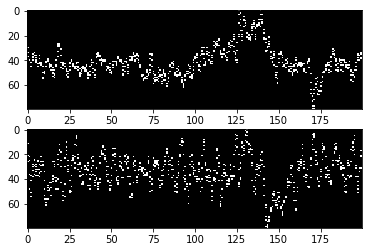

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.imshow(train_data[1][0].squeeze(0), interpolation='nearest', cmap='gray', aspect='auto')
ax2.imshow(train_data[0][0].squeeze(0), interpolation='nearest', cmap='gray', aspect='auto')
plt.show()

In [ ]:
ts_1.shape

torch.Size([10, 876])

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, stride=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                nn.Conv2d(32, 64, kernel_size=3, stride=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25), # activation layer
                nn.Conv2d(64, 64, kernel_size=5, stride=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)) # activation layer
        
        self.drop_out = nn.Dropout2d(0.3)
        self.fc_layers =nn.Sequential(nn.Linear(9856, 7))# define fully connected layer
    
    def forward(self, x):
        x = self.conv_layers(x) # pass input through conv layers
        x = self.drop_out(x)  
        x = x.view(x.shape[0], -1) # flatten output for fully connected layer, batchize,-1 do whatever it needs to be 
        x = self.fc_layers(x)# pass  through fully connected layer
        x = F.softmax(x, dim=1) #softmax activation function on outputs, get probability disatribution on output, all ouputs add to 1
        return x 

learning_rate = 0.001
epochs = 100

cnn = ConvNet().to(device) # to instantiate model
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr= learning_rate)

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

In [ ]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
dataset_sizes = {'train':len(train_loader.dataset), 'validation':len(val_loader.dataset)}

In [ ]:
def train_model(model, criterion, optimiser, epochs, verbose= True, tag ='Loss/Train'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    Liveloss= PlotLosses()
    #Iterate through epochs
    for epoch in range(epochs):
        logs = {}
        print('Epoch{}/{}'.format(epoch, epochs-1))
        print('-' * 15)
  
        #Each epoch has a training and validation phase        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
              
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for index, (inputs, labels) in enumerate (dataloaders[phase]):
                inputs,labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1) # flatten
                labels = labels.long()
                prediction = model(inputs) 
                prediction = prediction.view(labels.size(0), -1)  #flatten
                loss = criterion(prediction, labels) #calculate the loss between predicted and ground truth
                optimiser.zero_grad() # zero the paratmeter gradients
                  
                if phase == 'train':
                    if verbose: print('Epoch:', epoch, '\tBatch:', index, '\tLoss', loss.item())
                    loss.backward()  
                    optimiser.step() # backward + optimize only if in training phase

                _, pred = torch.max(prediction, dim= 1)                  
                running_loss += loss.detach() * inputs.size(0) 
                running_corrects += torch.sum(pred == labels.data)

             # calculate average losses fo the entire epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                
            logs[prefix + ' loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
                                    
            #Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

        Liveloss.update(logs)
        Liveloss.send()

    time_elapse = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapse // 60, time_elapse % 60))
    print('Best Val Acc: {}'.format(best_acc)) 
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
cnn = train_model(cnn, criterion, optimiser, epochs)